In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


sr = pd.read_csv("geodata.csv")

In [36]:
def Haversine(lat1,lon1,lat2,lon2, **kwarg):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6371.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
   
    return round(d,1)

In [37]:
sr['distance']=Haversine(sr['src_latitude'],sr['src_longitude'],sr['dst_latitude'],sr['dst_longitude'])

1. The empiric distribution

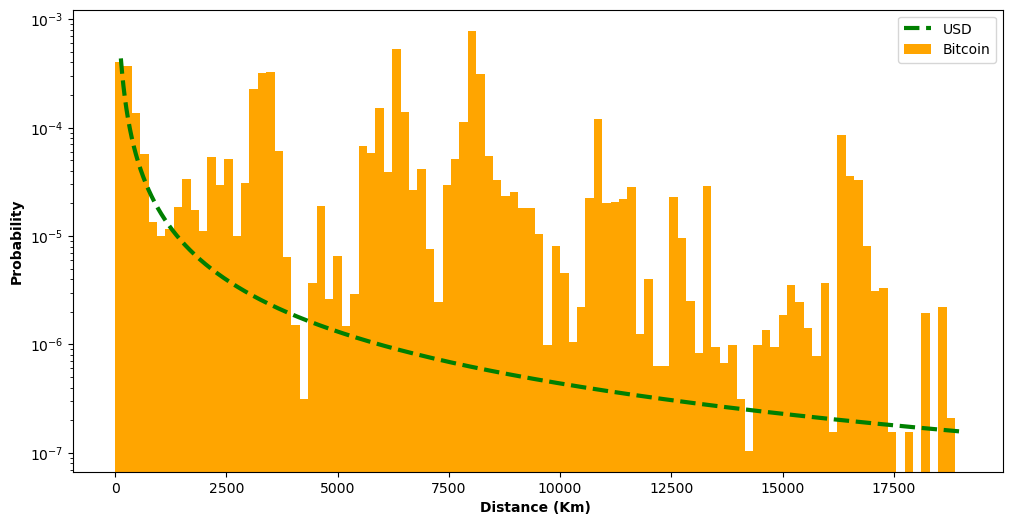

In [38]:

def pw(x):
    ans = x**(-1.59)
    return ans
x = np.linspace(130, 19000, 1000000)



fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.hist(sr['distance'],bins=100, density=True, color='orange')
plt.plot(x, pw(x), color='green', linestyle='--', lw=3)

axs.set_yscale('log')
plt.xlabel('Distance (Km) ', fontsize=10, weight='bold')
plt.ylabel('Probability', fontsize=10, weight='bold')
plt.legend(['USD', 'Bitcoin'])


plt.show() 


2. Calculate the correlation

In [39]:
sr_corr = sr.copy()
sr_corr.drop(['src_user', 'dst_user', 'txID'], axis=1, inplace=True)
corr = sr_corr.corr()
corr.style.background_gradient(cmap='coolwarm', axis= None).set_precision(3)

C:\Users\Asus\AppData\Local\Temp\ipykernel_11184\4239006306.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = sr_corr.corr()
C:\Users\Asus\AppData\Local\Temp\ipykernel_11184\4239006306.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm', axis= None).set_precision(3)


,src_latitude,src_longitude,value,timestamp,dst_latitude,dst_longitude,distance
src_latitude,1.000,-0.314,-0.017,0.003,0.035,0.044,-0.363
src_longitude,-0.314,1.000,0.021,0.007,0.019,0.062,0.160
value,-0.017,0.021,1.000,-0.057,-0.015,-0.008,0.003
timestamp,0.003,0.007,-0.057,1.000,0.052,0.082,0.023
dst_latitude,0.035,0.019,-0.015,0.052,1.000,-0.036,-0.330
dst_longitude,0.044,0.062,-0.008,0.082,-0.036,1.000,0.512
distance,-0.363,0.160,0.003,0.023,-0.330,0.512,1.000


3. Waiting time

In [ ]:
# todo

4. The in- and out-degree

In [41]:
sender = list(sr['src_user'])
receiver = list(sr['dst_user'])

users = sender + receiver

user_s = {}
user_r = {}

for i in users:
    if i not in user_s.keys():
        user_s[i] = 0
        user_r[i] = 0
    
for i in receiver:
    user_r[i] += 1
for i in sender:
    user_s[i] += 1    

In [42]:
tx_in = list(user_s.values())
tx_out = list(user_r.values())

tx_in_index = []
tx_out_index = []

for i in range(max(tx_in)+1):
    tx_in_index.append(0)
    
for i in tx_in:
    tx_in_index[int(i)] += 1   
    
for i in range(max(tx_out)+1):
    tx_out_index.append(0)
    
for i in tx_out:
    tx_out_index[int(i)] += 1   

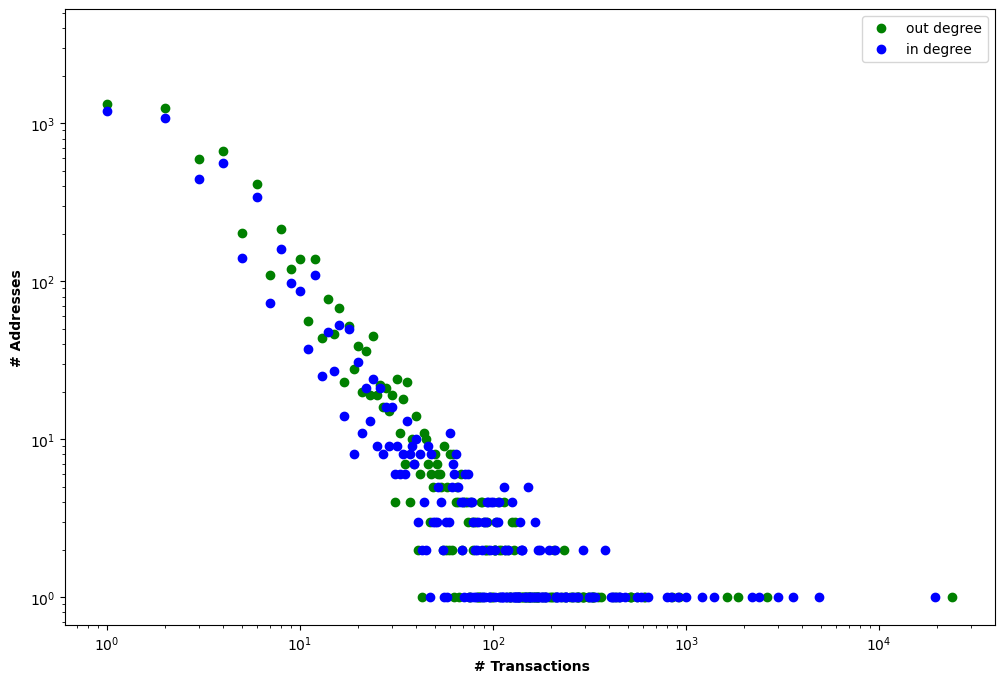

In [43]:
numb_tx1 = range(len(tx_in_index))
numb_tx2 = range(len(tx_out_index))

plt.figure(figsize=(12, 8)) 
plt.loglog(numb_tx1, tx_in_index,'go', label='out degree') 
plt.loglog(numb_tx2, tx_out_index,'bo', label='in degree') 
plt.legend(fontsize=10)

plt.xlabel(' # Transactions', fontsize=10, weight='bold')
plt.ylabel('# Addresses', fontsize=10, weight='bold')

plt.show()

In [44]:
!pip install powerlaw


In [45]:
import powerlaw

fit1 = powerlaw.Fit(np.array(tx_in)+1,xmin=1,discrete=True)
fit2 = powerlaw.Fit(np.array(tx_out)+1,xmin=1,discrete=True)



print('alpha1= ',fit1.power_law.alpha,'  alpha2= ',fit2.power_law.alpha)

alpha1=  1.5125917790668306   alpha2=  1.5878385861004027


5. Chinese transactions

In [46]:
sr_all = sr.copy()
sr_all = sr_all[16350:55480]  
sr_all['Sent from China'] = sr_all['src_country'] == 'CN'
sr_all['Sent from other country'] = sr_all['src_country'] != 'CN'
sr_all1 = sr_all[['timestamp', 'Sent from China', 'Sent from other country']]
sr_all1['timestamp'] = pd.to_datetime(sr_all1['timestamp'], unit='s')
sr_all1['timestamp'] = pd.to_datetime(sr_all1['timestamp']).dt.to_period(freq="D")
sr_all1 = sr_all1.set_index('timestamp')
sr_all1 = sr_all1.resample('4D').apply(np.sum)

C:\Users\Asus\AppData\Local\Temp\ipykernel_11184\2989255577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_all1['timestamp'] = pd.to_datetime(sr_all1['timestamp'], unit='s')
C:\Users\Asus\AppData\Local\Temp\ipykernel_11184\2989255577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_all1['timestamp'] = pd.to_datetime(sr_all1['timestamp']).dt.to_period(freq="D")


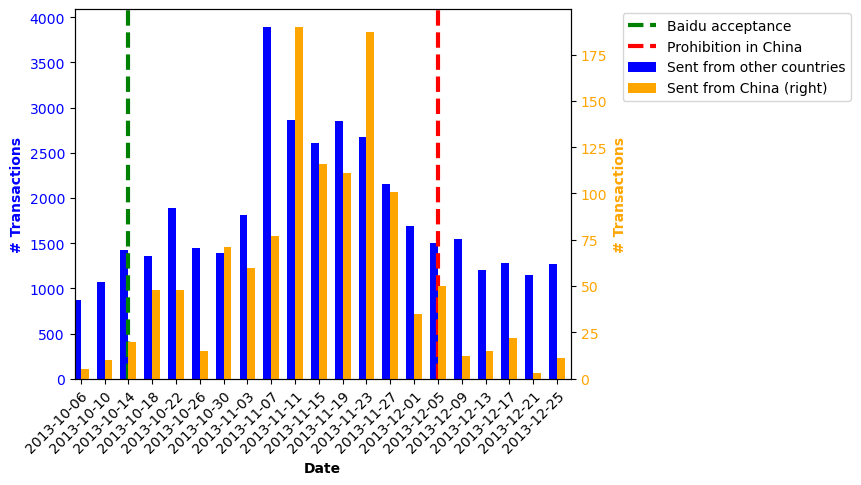

In [47]:
fig, ax = plt.subplots()

width=0.33

plt.axvline(x = 2, color='green', label= 'Baidu acceptance',  linestyle = '--', lw=3)
plt.axvline(x = 15, color='red', label= 'Prohibition in China',  linestyle = '--', lw=3)

sr_all1['Sent from other country'].plot.bar(ax=ax, x='datetime', label="Sent from other countries", legend=False, color='b', position=1,  width=width)
ax.set_ylabel('# Transactions', color='b', fontsize=10, weight='bold')
ax.tick_params(axis='y', labelcolor='b')

ax2 = sr_all1['Sent from China'].plot.bar(ax=ax, x='datetime',  secondary_y=True, label="Sent from China", legend=False, color='orange', position=0,  width=width)
ax2.set_ylabel('# Transactions', color='orange', fontsize=10, weight='bold')
ax2.tick_params(axis='y', labelcolor='orange')

fig.legend(loc= 'center left', bbox_to_anchor=(0.97, 0.78))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_xlabel('Date', fontsize=10, weight='bold' )
plt.show()

6. Value-distance distribution

In [66]:
data = []
for i in range(12):
    data.append([0,0,0,0,0,0,0,0,0,0,0,0])

In [67]:
sr1 = sr.copy()
sr1['value']=sr1['value']*100000000
sr_without0 = sr1[sr1['value'] != 0]

npdis = sr_without0['distance'].to_numpy()
npval = sr_without0['value'].to_numpy()
npval = np.log10(npval)

for i in range(101336):
    
    valu = npval[i]
    dist = npdis[i]
    
    for j in range(12):
        if valu >= j:
            if valu < j+1:
                for k in range(12):
                    if dist >= column[k]:
                        if dist < column[k+1]:
                            data[j][k] += 1

In [68]:
table = pd.DataFrame(data, columns=[0, 1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, 13500, 15000, 16500])

Text(73.32222222222227, 0.5, 'Value (Satoshi)')

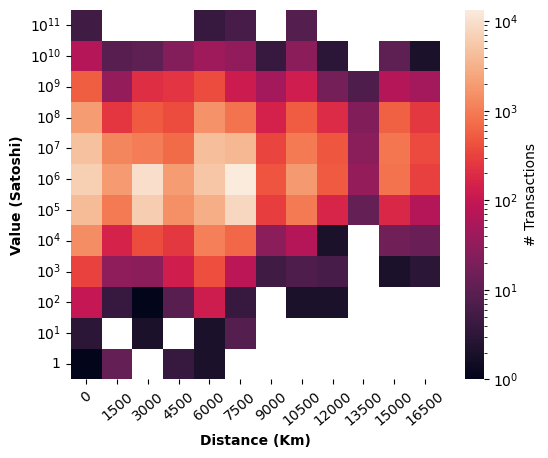

In [69]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import matplotlib.ticker as ticker

g_vals = np.logspace(0, 11, 12)

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tg = [u"${}$".format(tick.format_data(x)) for x in g_vals]


ax = sns.heatmap(table, cmap='rocket', cbar_kws={'label': '# Transactions'},square=True, norm=LogNorm(), yticklabels=tg)
ax.invert_yaxis()
ax.tick_params(axis='x', rotation=40)
plt.xlabel('Distance (Km)', fontsize=10, weight='bold')
plt.ylabel('Value (Satoshi)', fontsize=10, weight='bold')

7. Making the heatmap

In [71]:
!pip install folium

                                              0.0/102.3 kB ? eta -:--:--
     --------------                        41.0/102.3 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 102.3/102.3 kB 1.5 MB/s eta 0:00:00


In [72]:
import folium
from folium.plugins import HeatMap
import os
import branca.colormap as cm
from collections import defaultdict

startingLocation = [42, 22]
hmap = folium.Map(location=startingLocation, zoom_start=2, tiles="cartodb positron")

colormap = cm.LinearColormap(colors=['blue', 'cyan','red'],
                             index=[100 , 1000, 10000], vmin=0, vmax=10000, caption='Total sent bitcoin')


hm_wide = HeatMap( list(zip(sr['src_latitude'], sr['src_longitude'], sr['value'])),
                        min_opacity=0.2,
                        max_val=20000,
                        radius=17, blur=15,
                        max_zoom=1)

hmap.add_child(hm_wide)
hmap.add_child(colormap)

C:\Users\Asus\AppData\Local\Temp\ipykernel_11184\2097822709.py:14: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  hm_wide = HeatMap( list(zip(sr['src_latitude'], sr['src_longitude'], sr['value'])),
